# <center>Логистическая регрессия на двумерных данных

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.Normal(torch.tensor([mu0, mu0]), torch.tensor([sigma0, sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1, mu1]), torch.tensor([sigma1, sigma1]))

### визуализируем пример сгенерированного обучающего датасета 

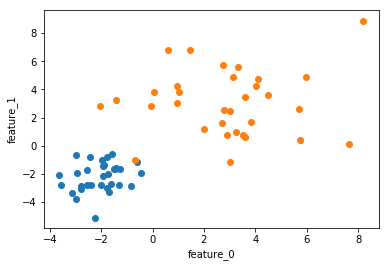

In [5]:
n = 32
d0_sample = d0.sample((n,))
d1_sample = d1.sample((n,))
plt.scatter(d0_sample[:, 0], d0_sample[:, 1])
plt.scatter(d1_sample[:, 0], d1_sample[:, 1])
plt.xlabel("feature_0")
plt.ylabel("feature_1");

### создаем и обучаем классификатор

In [6]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([0.4785, 0.0117]), tensor(0.3009)]


In [7]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        # промежуточное валидирование:
        # делаем промежуточный прогноз и считаем на нем ошибку,
        # предварительно отключаем расчет градиентов (для экономии памяти, для предикта он не нужен), 
        # делаем это внутри контекстного менеджера, чтобы не нарушать общий ход вычислений
        # (внутри него это изолируется)
        with torch.no_grad():        
            x, y = sample(d0, d1, 100000)  # делаем валидационную выборку
            out = torch.sigmoid(layer(x))  # предикт (форвард проход)
            loss = F.binary_cross_entropy(out, y)  # функционал ошибки, правдоподобие
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)  # генерим "на лету" очередной обучающий батч
    out = torch.sigmoid(layer(x))  # прямой проход (форвард), считаем очередное приближение
    loss = F.binary_cross_entropy(out, y)  # функционал-ошибка, который мы оптимизируем
    loss.backward()  # считаем градиенты по каждому параметру (через обратное распространение ошибки)
    layer_opt.step()  # делаем шаг против градиента в соответствие с выбранным алгоритмом "шагания"

Ошибка после 0 итераций: 0.325614
Ошибка после 1 итераций: 0.181103
Ошибка после 2 итераций: 0.133051
Ошибка после 3 итераций: 0.108243
Ошибка после 4 итераций: 0.093659
Ошибка после 5 итераций: 0.083714
Ошибка после 6 итераций: 0.075788
Ошибка после 7 итераций: 0.070197
Ошибка после 8 итераций: 0.066064
Ошибка после 9 итераций: 0.063108
Ошибка после 10 итераций: 0.058703
Ошибка после 11 итераций: 0.056810
Ошибка после 12 итераций: 0.055516
Ошибка после 13 итераций: 0.053516
Ошибка после 14 итераций: 0.051217
Ошибка после 15 итераций: 0.050183
Ошибка после 16 итераций: 0.048636
Ошибка после 17 итераций: 0.047880
Ошибка после 18 итераций: 0.047218
Ошибка после 19 итераций: 0.046682


### визуализируем обученные области-классы и вероятности

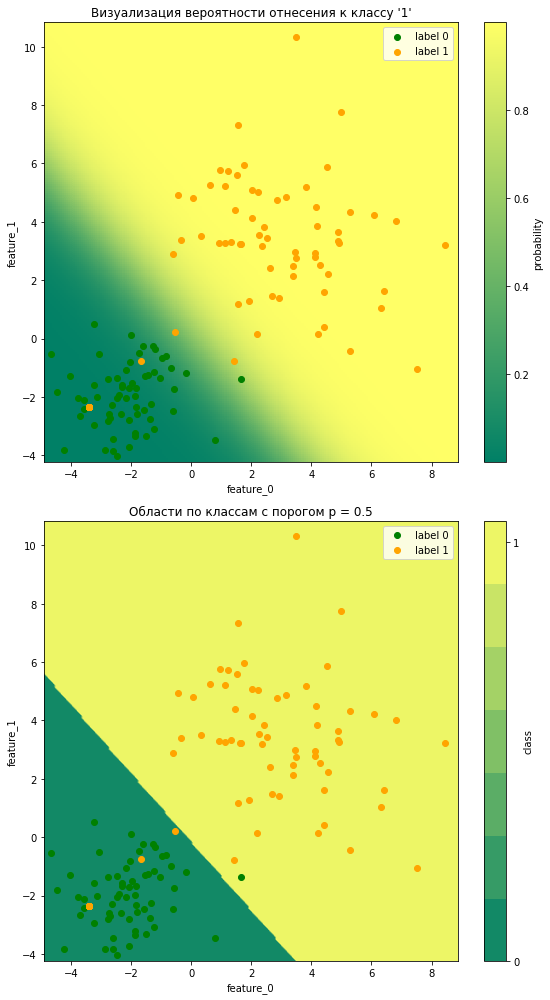

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

X_val, y_val = sample(d0, d1, 64)

n_classes = 2
plot_colors = ['g', 'orange']
steps = 200

x_min, x_max = X_val[:, 0].min() * 1.05, X_val[:, 0].max() * 1.05
y_min, y_max = X_val[:, 1].min() * 1.05, X_val[:, 1].max() * 1.05

xx, yy =  torch.meshgrid(torch.linspace(x_min, x_max, steps),
                         torch.linspace(y_min, y_max, steps))

with torch.no_grad():
    pred = torch.sigmoid(layer(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)))  # предикт (форвард проход)

pred = pred.reshape(xx.shape)
p = 0.5
preds_class = (pred.data.numpy() > p).astype(int)

# визуализация
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 14))

sub0 = axes[0].pcolormesh(xx, yy, pred, cmap='summer')
axes[0].set_title("Визуализация вероятности отнесения к классу '1'")
fig.colorbar(sub0, ax=axes[0], label="probability")
sub1 = axes[1].contourf(xx, yy, preds_class, cmap='summer')
axes[1].set_title(f"Области по классам с порогом p = {p}")
fig.colorbar(sub1, ax=axes[1], ticks=[0, 1], label='class')

for ax in axes:
    for i, color in zip(range(n_classes), plot_colors):
        indexes = np.where(y_val == i)
        ax.scatter(X_val[indexes, 0], 
                    X_val[indexes, 1], 
                    c=color, 
                    label=f"label {i}",
                    cmap='Accent')
        ax.set_xlabel("feature_0")
        ax.set_ylabel("feature_1")
        ax.legend()
fig.tight_layout()